<a href="https://colab.research.google.com/github/jadrk040507/machine-learning/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

In this notebook we will be using the MNIST dataset which is commonly used dataset in ML. It contains 70,000 images of handwritten data.
Let's begin by importing the data.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets in Scikit-Learn have a similar structure:

* A `DESCR` key describing the dataset
* A `data` key containing an array with one row per instance and one column per feature
* A `target` key containing an array with labels

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


Since data describes pixel color, we will use `matplotlib` to display visually the data.

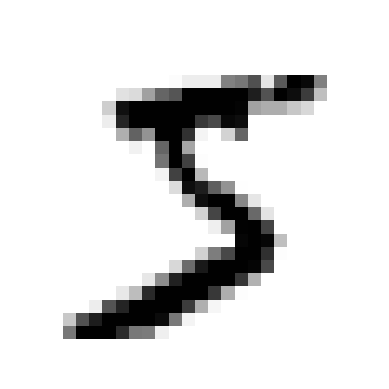

5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print(y.iloc[0])

Note the label is a string. We must therefore cast it into integers.

In [4]:
import numpy as np
y = y.astype(np.uint8)

Since the dataset is already shuffled randomly, we can proceed to create the different datasets for trainin and testing.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's begin with a SGD classifier (Stochastic Gradient Descent).This will distinguish into two classes. But first, we need to create a single number detector, in this case $5$.

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now, let's use it to detect images of the number 5.

In [8]:
sgd_clf.predict(X_train.iloc[[0]]) # Correctly classified the first value

array([ True])

## Performance Measures

A good way to measure performance is to use cross-validation. Cross validation is a technique used to see how well does the model generalizes with unseen data. This technique basically consists on subdividing the training set into $k$ equal parts, called folds, then, train the model with $k-1$ and test it with the remainind set. This process is repeated with each fold.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


We can use the `cross_val_score()` to evaluate the model using cross validation with three folds.

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Those are high accuracy values. But before we get too excited, let's look at a dumb classifier that classifies every image in the "not-5" class.

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

It seems this criteria is not very useful in this case. This is simply because about 10% of the images are 5s, so if you alwas say an image is not a 5, you will be right about 90% of the times.

## Precision and Recall

Taking a look to the confusion matrix is a better way to evaluate the performance of the model. The idea is to count the number of times class A are classified as class B, etc. It will become clearer when we visualize the matrix.

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row represents an *actual class*, while each column represents a *predicted class*. The matrix must be interpreted as:

* Upper left = true negative (TN)
* Upper right = false positives (FP)
* Lower left = false negatives (FN)
* Lower right = true positives (TP)

From the matrix, we can obtain several metrics. The first one is *accuracy* (also called *precision*) of the positive predictions.

$
\text{precision} = \frac{TP}{TP+FP}
$

Note that a trivial way to have perfecto precision is to make one single positive prediction and ensure its correct ($\text{precision}=1/1=100\%$). This is not very useful. That's why we use precision along with another metric named *recall* (also called *sensitivity*).

$
\text{recall} = \frac{TP}{TP+FN}
$

Let's return to Scikit-Learn to compute these metrics.

In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


We should interpret the following as: "when the model claims an image represents a 5, it is correct only 83% of the time". Now, for recall it should be: "the model only detects 65% of the 5s".

Sometimes it's convenient to combine precision and recall into a single metric $F_1$. The $F_1$ score is a *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

$$
F_1
= \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}
= 2 \times \frac{\text{precision}\,\times\,\text{recall}}
       {\text{precision} + \text{recall}}
= \frac{TP}{TP + \tfrac{FP + FN}{2}}
$$


In [15]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print(f1)

0.7325171197343847




## Precision/Recall Tradeoff
The precision/recall tradeoff explains how changing a classifier’s decision threshold affects its performance: increasing the threshold raises precision by reducing false positives but lowers recall by missing more true positives. Lowering the threshold does the opposite—boosts recall but may reduce precision. Balancing the threshold helps optimize for the metric most important to the task.

In Scikit-Learn you cannot set a custom threshold, yet by using `predict()` you can call is `decision_function()` method which returns a score from where we can set our own threshold.

In [16]:
some_digit = X.iloc[[0]]
y_scores = sgd_clf.decision_function(some_digit)
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


`SGDClassifier` uses a threshold equal to $0$. But we could raise another threshold, let's say 4000.

In [17]:
threshold = 4000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


How do you decide which threshold to use taking into account the tradeoff? We can plot a precision-recall curve to have an insight.

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


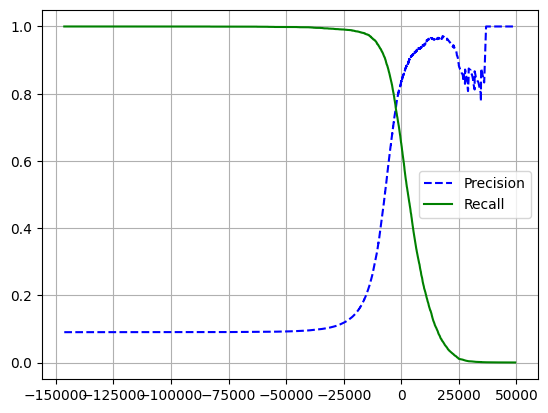

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Another way is by plotting a locus curve.

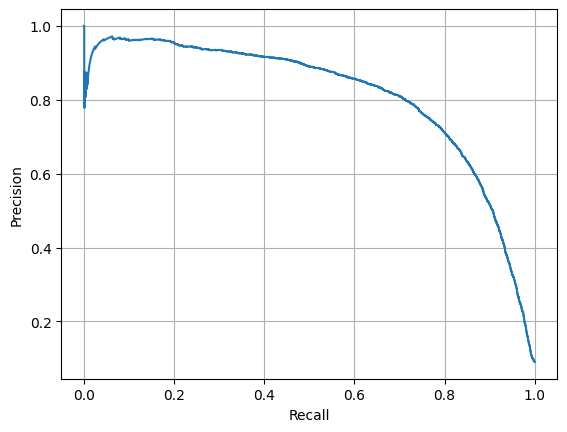

In [20]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

The selected combinationdepends on your project. In some cases you cannot risk on missclassifying, while on others you might want to prioritize detection.

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


Not so fast! A high precision is not very useful if its recall is too low!

## The ROC Curve

The *receiver operating characteristic* (ROC) curve is similar to the precision/recall curve, the ROC curve plots the *true positive rate* (recall) against the *false positive rate*. The FPR is the ratio of instances incorrectly classified as positive. It is equal to one minus de *true negative rate*, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*.
Hence, the ROC plots *sensitivity* (recall) against 1-*specificity*.

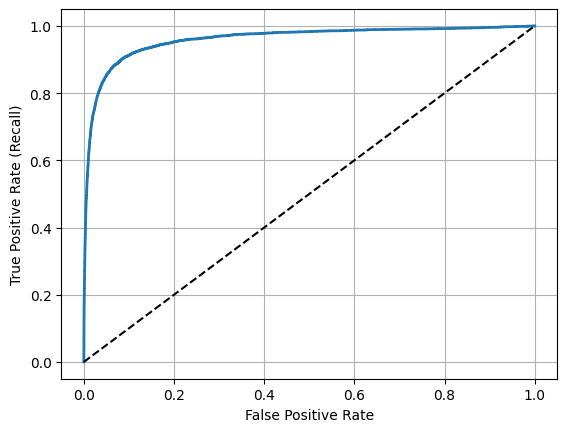

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()
    plt.show()

plot_roc_curve(fpr, tpr, label=None)

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

Let's try training a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to `SGDClassifier`.

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [24]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

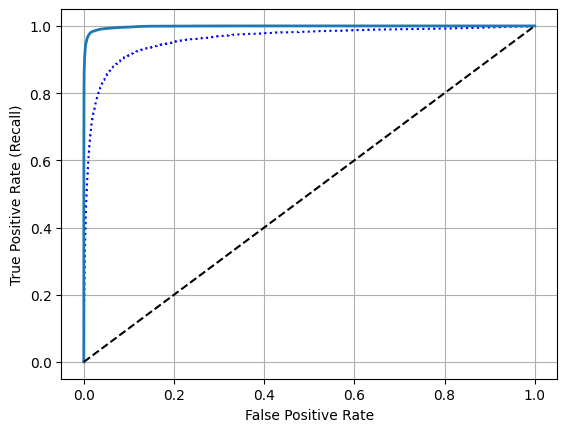

In [25]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.legend(loc="lower right")
plt.show()

## Multiclass Classification

Some algorithms (such as Random Forest or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers can distinguish or Linear classifiers) are strictly binary.

There are several strategies to do multinomial classification:

1. One-Versus-All (OvA): generates a decision score from each classifier and then chooses the class with highest score.
2. One-Versus-One (OvO): trains a binary classifier for every pair of combinations. If there are $N$ classes, you will need to train $N\times(N-1)/2$ classifiers.

In [26]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

array([3], dtype=uint8)

In this case `SGDClassifier` automatically runs OvA and detects that there are 10 classes. Let's see the decision function for `some_digit` (remember this was the number 5).

In [27]:
some_digit_scores = sgd_clf.decision_function(some_digit)
print(some_digit_scores)
print(np.argmax(some_digit_scores))

print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
3
[0 1 2 3 4 5 6 7 8 9]
5


If you want to force Scikit-Learn to use OvO or OvA, you can pass the function under `OneVsOneClassifier` or `OneVsRestClassifier`.

In [28]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(some_digit)

array([5], dtype=uint8)

Training the model with Random Forest is just as easy. Since the latter can fit multiclass models the OvO/OvA class are not necessary.

In [29]:
forest_clf.fit(X_train, y_train)
forest_clf.predict(some_digit)

array([5], dtype=uint8)

In [30]:
forest_clf.predict_proba(some_digit)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

## Error Analysis

Let's analyze the type of error the models make.

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5635    0   61   10   16   50   46    7   66   32]
 [   3 6393   95   21   16   47   15   27  109   16]
 [  72   56 5174   89   69   39  163   66  212   18]
 [  58   32  217 4941   23  441   32   56  216  115]
 [  11   26   46    6 5298   26   73   32   87  237]
 [  68   23   58  150   83 4606  174   26  152   81]
 [  40   13   56    6   22  113 5625    5   36    2]
 [  23   24  103   36  124   40   10 5228   75  602]
 [  40  101  158  122   49  457   77   35 4666  146]
 [  33   18   66   83  515  127    4  485  166 4452]]


Let's try visualizing the confusion matrix.

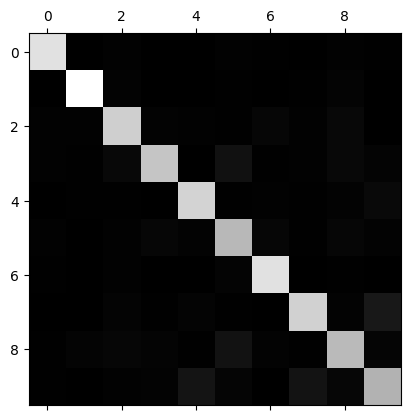

In [32]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let's plot it again, but now dividing the count values wiht its mean.

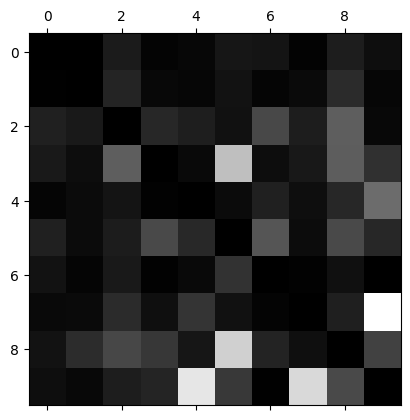

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

Sometimes we do not only want to classify to a single category. Instead, there are cases we want to assign multiple classifications per instance, this is called multilabel classification. One example of this are multiple face recognition on photos.

In [34]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_multilabel)
knn_classifier.predict(some_digit)

array([[False,  True]])

Let's use the $F_1$ score to asses the model.

In [35]:
y_train_knn_pred = cross_val_predict(knn_classifier, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048